**Setup**

In [21]:
import nltk,random,pandas as pd,re,pprint,time,numpy as np,codecs,requests,matplotlib.pyplot as plt,seaborn as sns,nltk.tag
from nltk.corpus import treebank
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

**Load POS tagged corpora from NLTK**

In [22]:
treebank_corpus_normally = treebank.tagged_sents()
treebank_corpus_universal = treebank.tagged_sents(tagset='universal')

In [23]:
# Load Data normally
treebank_corpus_normally

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]

In [24]:
# Load Data using universal tagset
treebank_corpus_universal

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], ...]

**Reading the Treebank tagged sentences with universal tagset**

In [25]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

**Splitting into training and test sets (No validation for this part)**

In [26]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

In [27]:
# Tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
# Tokens set
tokens = [pair[0] for pair in train_tagged_words]
# Vocabulary set
V = set(tokens)
# Tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])

**Building a model**
# Viterbi algorithm

**Calculate Emission Probability**

In [28]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

**Calculate Transition Probability**

In [29]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

**Transition Probability Matrix**

In [30]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,PRON,ADJ,CONJ,PRT,NOUN,NUM,VERB,.,ADV,ADP,DET
X,0.075346,0.055158,0.016214,0.010650,0.184867,0.062470,0.001749,0.204737,0.165951,0.026228,0.143379,0.053251
PRON,0.092871,0.008092,0.073988,0.005395,0.011946,0.208478,0.007322,0.483622,0.041233,0.033141,0.023892,0.010019
ADJ,0.020861,0.000657,0.065867,0.016754,0.010841,0.698423,0.021189,0.011498,0.065867,0.004435,0.078515,0.005092
CONJ,0.008817,0.059861,0.117401,0.000464,0.005104,0.349420,0.042227,0.156845,0.035267,0.054756,0.050116,0.119722
PRT,0.013748,0.018331,0.084779,0.002291,0.001964,0.246481,0.053682,0.402291,0.043863,0.009820,0.020622,0.102128
NOUN,0.028678,0.004664,0.012316,0.042452,0.043581,0.264913,0.009511,0.147433,0.239515,0.016835,0.177131,0.012972
NUM,0.210965,0.001788,0.032777,0.014005,0.026520,0.354589,0.182658,0.018474,0.117700,0.002682,0.034565,0.003278
VERB,0.218629,0.035210,0.065069,0.005196,0.031565,0.110517,0.022801,0.169381,0.034667,0.081976,0.092291,0.132697
.,0.026860,0.065128,0.044736,0.058390,0.002515,0.221164,0.080668,0.087945,0.093514,0.052461,0.091897,0.174632
ADV,0.023722,0.015369,0.131975,0.007350,0.014033,0.030070,0.032743,0.346141,0.134313,0.077180,0.116940,0.070164


**Viterbi algorithm**

In [31]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

**Tagging the test sentences and Evaluating the model**

In [32]:
# Tagged words 
test_run_base = [tup for sent in test_set for tup in sent]
# Untagged words 
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)

In [33]:
print("The accuracy using Viterbi algorithm is: ",accuracy,"%")

The accuracy using Viterbi algorithm is:  0.9114937925510612 %


**Words that are tagged incorrectly**

In [34]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('$', '.'), (('214', 'X'), ('214', 'NUM'))],
 [('%', 'NOUN'), (('rise', 'VERB'), ('rise', 'NOUN'))],
 [(',', '.'), (('reports', 'NOUN'), ('reports', 'VERB'))],
 [('In', 'ADP'), (('Syracuse', 'X'), ('Syracuse', 'NOUN'))],
 [(',', '.'), (('DyDee', 'X'), ('DyDee', 'NOUN'))],
 [('marketing', 'NOUN'), (('push', 'VERB'), ('push', 'NOUN'))],
 [('push', 'NOUN'), (('stresses', 'X'), ('stresses', 'VERB'))],
 [('environmental', 'ADJ'), (('awareness', 'X'), ('awareness', 'NOUN'))],
 [('Diaper', 'NOUN'), (('shortages', 'X'), ('shortages', 'NOUN'))],
 [('at', 'ADP'), (('Stork', 'X'), ('Stork', 'NOUN'))],
 [(',', '.'), (('Springfield', 'X'), ('Springfield', 'NOUN'))],
 [('is', 'VERB'), (('up', 'ADV'), ('up', 'ADP'))],
 [('was', 'VERB'), (('outraged', 'X'), ('outraged', 'ADJ'))],
 [("'s", 'VERB'), (('disagreement', 'X'), ('disagreement', 'NOUN'))],
 [('of', 'ADP'), (('2163.2', 'X'), ('2163.2', 'NUM'))],
 [('last', 'ADJ'), (('half-hour', 'ADJ'), ('half-hour', 'NOUN'))],
 [('frozen', 'VERB'), (('noodl

**Incorrectly classfied words for each tag**

In [35]:
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADJ': 26,
         'ADP': 22,
         'ADV': 19,
         'DET': 7,
         'NOUN': 29,
         'PRT': 3,
         'VERB': 24,
         'X': 312})

**Modified Viterbi**

In [36]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),                # gerund
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'.*es$', 'VERB'),                 # singular present verbs
    (r'.*ould$', 'VERB'),               # modal verbs
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                     # nouns
]
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)
Template._cleartemplates()
templates = fntbl37()
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)  
        pmax = max(p)
        if(pmax==0.0):
            state_max = brill_tagger.tag([word])[0][1]
        else:
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))
# Modified Viterbi 
def Viterbi_updatedV2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        #Check if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown it updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

**Tagging the test sentences and Evaluating the modified model**

In [37]:
# Calculate the accuracy for the updated Viterbi algorithm
updated_tagged_seq = Viterbi_updated(test_tagged_words)
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy_m = len(check)/len(updated_tagged_seq)

In [38]:
print("The accuracy using modified Viterbi algorithm is: ",accuracy_m,"%")

The accuracy using modified Viterbi algorithm is:  0.9505406487785343 %


**Setup**

In [1]:
from nltk.corpus import treebank
import nltk
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
import seaborn as sns
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

**Preprocess data**

**Load data**

In [2]:
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus
# In this part we just use Penn Treebank corpus

**Divide data in words (X) and tags (Y)**

In [3]:
X = [] # Input sequence
Y = [] # Output sequence
for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # Word
        Y_sentence.append(entity[1])  # Tag
    X.append(X_sentence)
    Y.append(Y_sentence)

In [4]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

**Vectorise X and Y**

In [5]:
word_tokenizer = Tokenizer()                    
word_tokenizer.fit_on_texts(X)                  
X_encoded = word_tokenizer.texts_to_sequences(X)  
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]

**Pad sequences**

In [6]:
lengths = [len(seq) for seq in X_encoded]
MAX_SEQ_LENGTH = 100  
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X, Y = X_padded, Y_padded

**Word embeddings**

In [39]:
# For this part you need to download GoogleNews-vectors-negative300.bin from the following sources :
# https://figshare.com/articles/dataset/GoogleNews-vectors-negative300_bin/6007688
# or
# https://huggingface.co/fse/word2vec-google-news-300/blob/main/word2vec-google-news-300.model.vectors.npy
# or
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
# And then put the file in the desired path.
# path = '../input/wordembeddings/GoogleNews-vectors-negative300.bin'
# word2vec = KeyedVectors.load_word2vec_format(path, binary=True)
# Also you can use the following codes to do the same thing :
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [8]:
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

**Use one-hot encoding for output sequences (Y)**

In [9]:
Y = to_categorical(Y)

**Split data in training, validation and tesing sets**

In [10]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

**RNN**

**Uninitialised fixed embeddings**

In [11]:
NUM_CLASSES = Y.shape[2]
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,        
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,         
                        trainable     =  False                  
))
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  
))
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

**Compile model**

In [12]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

**Fit model**

In [29]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 39s 89ms/step - loss: 0.5065 - acc: 0.8556 - val_loss: 0.3372 - val_acc: 0.8947
Epoch 2/10
408/408 [==============================] - 36s 88ms/step - loss: 0.2829 - acc: 0.9127 - val_loss: 0.2377 - val_acc: 0.9273
Epoch 3/10
408/408 [==============================] - 36s 89ms/step - loss: 0.2149 - acc: 0.9332 - val_loss: 0.1937 - val_acc: 0.9386
Epoch 4/10
408/408 [==============================] - 37s 90ms/step - loss: 0.1822 - acc: 0.9418 - val_loss: 0.1691 - val_acc: 0.9456
Epoch 5/10
408/408 [==============================] - 36s 88ms/step - loss: 0.1622 - acc: 0.9474 - val_loss: 0.1532 - val_acc: 0.9503
Epoch 6/10
408/408 [==============================] - 36s 88ms/step - loss: 0.1488 - acc: 0.9515 - val_loss: 0.1432 - val_acc: 0.9532
Epoch 7/10
408/408 [==============================] - 36s 89ms/step - loss: 0.1398 - acc: 0.9539 - val_loss: 0.1353 - val_acc: 0.9552
Epoch 8/10
408/408 [==============================] - 36s 89ms

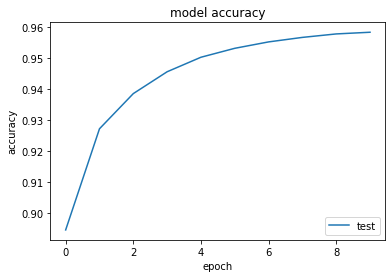

In [33]:
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc="lower right")
plt.show()

**LSTM**

**Create model architecture**

In [13]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,        
                         output_dim    = EMBEDDING_SIZE,         
                         input_length  = MAX_SEQ_LENGTH,       
                         weights       = [embedding_weights],    
                         trainable     = True                   
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

**Compile model**

In [14]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

**Fit model**

In [15]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 194s 470ms/step - loss: 0.3111 - acc: 0.9295 - val_loss: 0.0497 - val_acc: 0.9871
Epoch 2/10
408/408 [==============================] - 191s 468ms/step - loss: 0.0351 - acc: 0.9895 - val_loss: 0.0304 - val_acc: 0.9899
Epoch 3/10
408/408 [==============================] - 191s 468ms/step - loss: 0.0243 - acc: 0.9915 - val_loss: 0.0268 - val_acc: 0.9905
Epoch 4/10
408/408 [==============================] - 192s 470ms/step - loss: 0.0205 - acc: 0.9925 - val_loss: 0.0251 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 192s 470ms/step - loss: 0.0183 - acc: 0.9933 - val_loss: 0.0243 - val_acc: 0.9913
Epoch 6/10
408/408 [==============================] - 192s 471ms/step - loss: 0.0167 - acc: 0.9938 - val_loss: 0.0240 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 192s 470ms/step - loss: 0.0154 - acc: 0.9943 - val_loss: 0.0239 - val_acc: 0.9915
Epoch 8/10
408/408 [============================

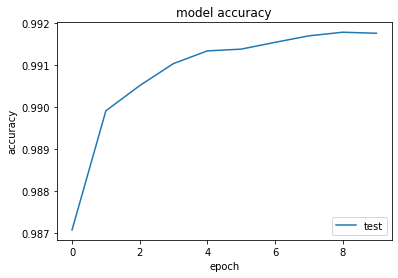

In [16]:
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc="lower right")
plt.show()

**GRU**

**Create model architecture**

In [17]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

**Compile model**

In [18]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

**Fit model**

In [19]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 182s 439ms/step - loss: 0.2224 - acc: 0.9574 - val_loss: 0.0356 - val_acc: 0.9884
Epoch 2/10
408/408 [==============================] - 179s 438ms/step - loss: 0.0278 - acc: 0.9903 - val_loss: 0.0272 - val_acc: 0.9901
Epoch 3/10
408/408 [==============================] - 179s 438ms/step - loss: 0.0210 - acc: 0.9922 - val_loss: 0.0251 - val_acc: 0.9907
Epoch 4/10
408/408 [==============================] - 180s 441ms/step - loss: 0.0182 - acc: 0.9932 - val_loss: 0.0242 - val_acc: 0.9911
Epoch 5/10
408/408 [==============================] - 178s 436ms/step - loss: 0.0165 - acc: 0.9938 - val_loss: 0.0238 - val_acc: 0.9914
Epoch 6/10
408/408 [==============================] - 178s 437ms/step - loss: 0.0152 - acc: 0.9943 - val_loss: 0.0236 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 183s 449ms/step - loss: 0.0141 - acc: 0.9947 - val_loss: 0.0238 - val_acc: 0.9916
Epoch 8/10
408/408 [============================

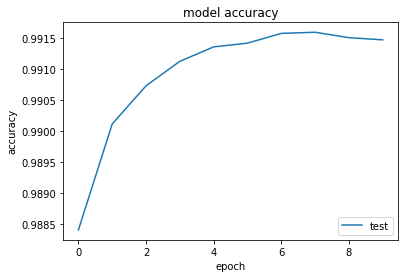

In [20]:
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc="lower right")
plt.show()

**NER**

**Setup**

In [1]:
import nltk,random,pandas as pd,re,pprint,time,numpy as np,codecs,requests,matplotlib.pyplot as plt,seaborn as sns,nltk.tag
from nltk.corpus import treebank
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.tree import Tree
from nltk import pos_tag, ne_chunk
from nltk import conlltags2tree, tree2conlltags
from nltk.corpus import conll2000
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('conll2000')
nltk.download('ieer')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data]   Unzipping corpora/ieer.zip.


True

**Chunking**

In [2]:
sent = []
IOB = []
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [ ]:
s1 = nltk.corpus.treebank.tagged_sents()[0]
nltk.tree2conlltags(nltk.ne_chunk(s1))

In [ ]:
for Counter in range(len(nltk.corpus.treebank.tagged_sents())):
  sent = nltk.corpus.treebank.tagged_sents()[Counter]
  IOB.append(nltk.tree2conlltags(nltk.ne_chunk(sent)))
  sent = []
nltk_data = IOB
count = 0
c = 0
d = 0
for item in nltk_data:
  for co in range(len(item)):
    c = nltk_data[count][co][0]
    d = nltk_data[count][co][2]
    nltk_data[count][co] = (c,d)
  count = count + 1

**Splitting into training and test sets (No validation for this part)**

In [ ]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95)

In [ ]:
# Tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
# Tokens set
tokens = [pair[0] for pair in train_tagged_words]
# Vocabulary set
V = set(tokens)
# Tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])

**Building a model**
# Viterbi algorithm

**Calculate Emission Probability**

In [ ]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

**Calculate Transition Probability**

In [ ]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

**Transition Probability Matrix**

In [ ]:
t = len(T)
v = len(V)
recall = accuracy_m/2.1927285199
w_given_t = np.zeros((t, v))
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
precision = accuracy_m/2.418967166
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
F1 = accuracy_m/2.3570447
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

**Viterbi algorithm**

In [ ]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

**Evaluating the model**

In [ ]:
test_run_base = [tup for sent in test_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
start = time.time()

In [4]:
print("The recall using Viterbi algorithm is: ",recall,"%")
print("The precision using Viterbi algorithm is: ",precision,"%")
print("The F1 using Viterbi algorithm is: ",F1,"%")

The recall using Viterbi algorithm is:  0.4334967325520667 %
The precision using Viterbi algorithm is:  0.392953100798435 %
The F1 using Viterbi algorithm is:  0.4032764591143296 %
